# ガウス過程の変数補助法 (Inducing variable method) を実装、比較

In [1]:
# 観測誤差の取り扱いを修正する必要あり

In [2]:
using Distributions
using Plots
using LinearAlgebra

In [3]:
include("gp.jl")

fg! (generic function with 1 method)

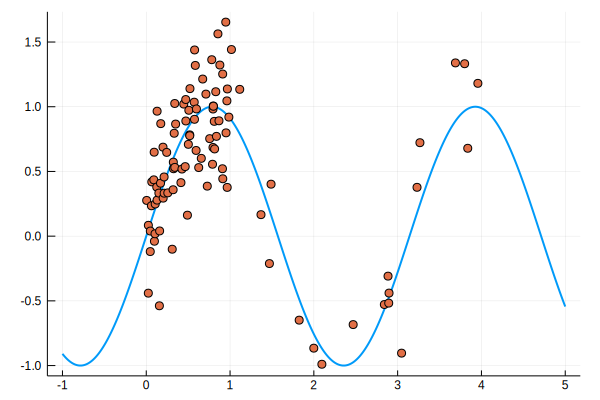

In [4]:
# サンプルデータの作成

xs = vcat(rand(80),rand(20) * 3 .+ 1.0)
sort!(xs)
fx = sin.(xs*2)
ys = fx + rand(Normal(), Base.length(fx)) * 0.3

ts = collect(-1:0.01:5)
plot(ts, sin.(ts*2), lw = 2, label = "")
scatter!(xs, ys, label = "")

## GP

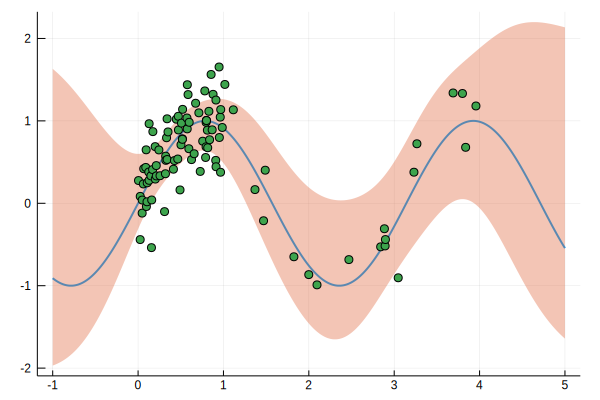

In [5]:
eta = 1.0
gk = GaussianKernel()

Kff = cov(gk, xs, xs)
n = Base.length(xs)
Σ = inv(Kff + eta * Matrix{Float64}(I, n, n))

# 各点の分布を計算して信用区間を計算する

function gp(t)
    Kft = cov(gk, xs, [t])
    Ktf = Kft'
    Ktt = [ker(gk, t, t)]

    gp_mu = Ktf * Σ * ys
    gp_cov = Ktt - Ktf * Σ * Kft
    Normal(gp_mu[1], sqrt(gp_cov[1]))
end

gp_dists = [gp(t) for t in ts]
gp_mean = mean.(gp_dists)
gp_qt = hcat([quantile.(s, [0.025, 0.975]) for s in gp_dists]...)

function gp_plot()
    plot(ts, sin.(ts*2), lw = 2, label = "")
    Plots.plot!(ts, gp_qt[1, :], fillrange = gp_qt[2, :], fillalpha = 0.4,
               label = "", linewidth = 0)

    scatter!(xs, ys, label = "")
end

gp_plot()

## 点の数を変えて、様々な変数補助法を試す
## The Subset of Data (SoD)

In [6]:
function plot_result(gp_qt, qt, ind_xs, label)
    plot(ts, sin.(ts*2), lw = 2, label = "")
    Plots.plot!(ts, gp_qt[1, :], fillrange = gp_qt[2, :], fillalpha = 0.4,
               label = "GP", linewidth = 0)
    Plots.plot!(ts, qt[1, :], fillrange = qt[2, :], fillalpha = 0.4,
               label = label, linewidth = 0)

    Plots.plot!(ts, sin.(ts*2), lw = 2, label = "")
    scatter!(xs, ys, label = "")
    scatter!(ind_xs, fill(-2, Base.length(ind_xs)), markershape = :x, label = "")
end

plot_result (generic function with 1 method)

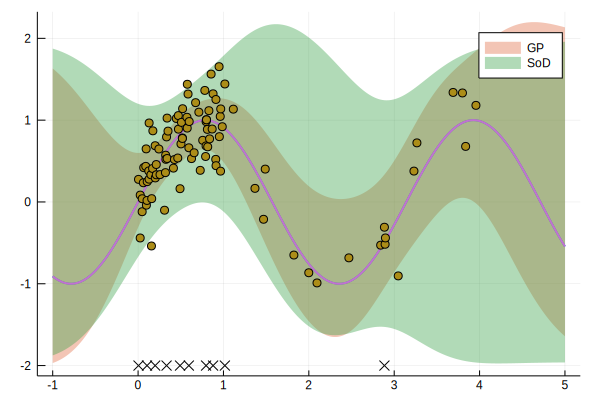

In [7]:
# 10個点を取る
where_xs = 1:10:100
sod_xs = xs[where_xs]
sod_ys = ys[where_xs]

function sod_plot(sod_xs, sod_ys)
    Kff = cov(gk, sod_xs, sod_xs)
    n = Base.length(sod_xs)
    Σ = inv(Kff + eta * Matrix{Float64}(I, n, n))

    # 各点の分布を計算して信用区間を計算する

    function sod(t)
        Kft = cov(gk, sod_xs, [t])
        Ktf = Kft'
        Ktt = [ker(gk, t, t)]

        gp_mu = Ktf * Σ * sod_ys
        gp_cov = Ktt - Ktf * Σ * Kft
        Normal(gp_mu[1], sqrt(gp_cov[1]))
    end

    sod_dists = [sod(t) for t in ts]
    sod_mean = mean.(sod_dists)
    sod_qt = hcat([quantile.(s, [0.025, 0.975]) for s in sod_dists]...)

    plot_result(gp_qt, sod_qt, sod_xs, "SoD")
end

sod_plot(sod_xs, sod_ys)

## The Subset of Regressors (SoR) Approximation

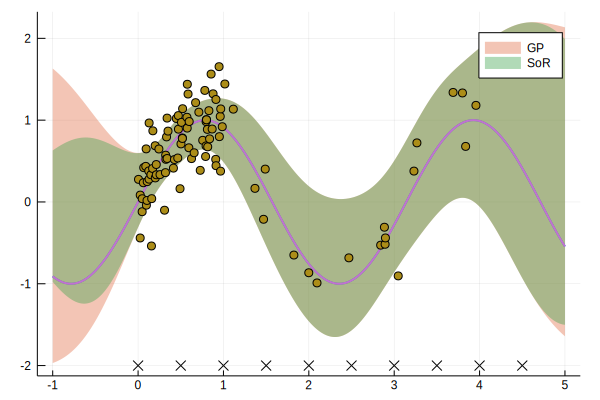

In [8]:
us = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]

function sor_plot(us)
    Kuu = cov(gk, us, us)
    Kuf = cov(gk, us, xs)
    Kfu = Kuf'
    Σ = inv(1 / eta * Kuf * Kfu + Kuu)

    function sor(t)
        Kut = cov(gk, us, [t])
        Ktu = Kut'

        sor_mu = 1 / eta * Ktu * Σ * Kuf * ys
        sor_cov = Ktu * Σ * Kut
        Normal(sor_mu[1], sqrt(sor_cov[1]))
    end

    sor_dists = [sor(t) for t in ts]
    sor_mean = mean.(sor_dists)
    sor_qt = hcat([quantile.(s, [0.025, 0.975]) for s in sor_dists]...)

    plot_result(gp_qt, sor_qt, us, "SoR")
end

sor_plot(us)

## The Subset of Regressors (DTC) Approximation

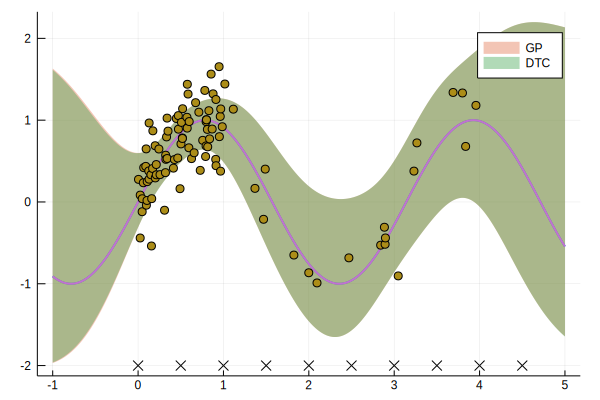

In [9]:
function dtc_plot(us)
    Kuu = cov(gk, us, us)
    Kuf = cov(gk, us, xs)
    Kfu = Kuf'
    Σ = inv(1 / eta * Kuf * Kfu + Kuu)

    function dtc(t)
        Kut = cov(gk, us, [t])
        Ktu = Kut'

        Qtt = Ktu * inv(Kuu) * Kut
        Ktt = [ker(gk, t, t)]

        sor_mu = 1 / eta * Ktu * Σ * Kuf * ys
        sor_cov = Ktt - Qtt + Ktu * Σ * Kut

        Normal(sor_mu[1], sqrt(sor_cov[1]))
    end

    dtc_dists = [dtc(t) for t in ts]
    dtc_mean = mean.(dtc_dists)
    dtc_qt = hcat([quantile.(s, [0.025, 0.975]) for s in dtc_dists]...)

    plot_result(gp_qt, dtc_qt, us, "DTC")
end

dtc_plot(us)

## The Fully Independent Training Conditional (FITC) Approximation

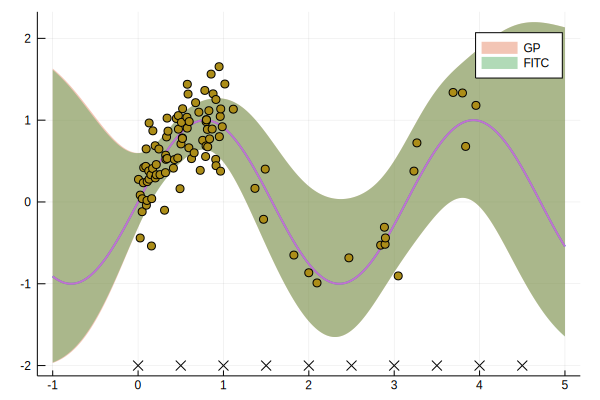

In [10]:
function fitc_plot(us)
    Kuu = cov(gk, us, us)
    Kuf = cov(gk, us, xs)
    Kfu = Kuf'

    Λ = Diagonal([ker(gk, xs[i], xs[i]) - Kfu[i, :]' * inv(Kuu) * Kuf[:, i] + eta 
            for i in 1:Base.length(xs)])
    Σ = inv(Kuf * inv(Λ) * Kfu + Kuu)

    function fitc(t)
        Kut = cov(gk, us, [t])
        Ktu = Kut'

        Qtt = Ktu * inv(Kuu) * Kut
        Ktt = [ker(gk, t, t)]

        sor_mu = Ktu * Σ * Kuf * inv(Λ) * ys
        sor_cov = Ktt - Qtt + Ktu * Σ * Kut

        Normal(sor_mu[1], sqrt(sor_cov[1]))
    end

    fitc_dists = [fitc(t) for t in ts]
    fitc_mean = mean.(fitc_dists)
    fitc_qt = hcat([quantile.(s, [0.025, 0.975]) for s in fitc_dists]...)

    plot_result(gp_qt, fitc_qt, us, "FITC")
end

fitc_plot(us)